<a href="https://colab.research.google.com/github/DCDPUAEM/DCDP/blob/master/02-Machine-Learning/notebooks/07-Perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Perceptrón

En esta notebook implementaremos el perceptrón y el perceptrón con kernel. Lo compararemos con los otros modelos lineales vistos hasta ahora: SVM y OLS.

Una versión más sofisticada del [perceptrón](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html) se encuentra implementado en scikit-learn. Sin embargo, lo implementaremos al tratarse de un algoritmo sencillo.

___

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#@title Función para graficar

def grafica(x_train,y_train,x_test,y_test):
    '''
    Grafica los datos de entrenamiento y prueba
    Entrada: Datos
    Salida: scatter plot con datos diferenciados
    '''
    fig,ax = plt.subplots(figsize=(6,5))
    clases = np.unique(y_train).astype(int)
    # --- Datos de entrenamiento ---
    ax.scatter(x_train[:,0][y_train==clases[0]], x_train[:,1][y_train==clases[0]],
               facecolor='blue', 
               marker='o', 
               edgecolor='royalblue',
               s=60,
               label='neg train')
    """Datos positivos de entrenamiento"""
    ax.scatter(x_train[:,0][y_train==clases[1]], x_train[:,1][y_train==clases[1]],
               facecolor='orangered', 
               marker='o', 
               edgecolor='orangered',
               s=60,
               label='pos train')
    # --- Datos de prueba ---
    ax.scatter(x_test[:,0][y_test==clases[0]], x_test[:,1][y_test==clases[0]],
               facecolor='royalblue', 
               marker='x', 
               s=45,
               label='neg test')
    ax.scatter(x_test[:,0][y_test==clases[1]], x_test[:,1][y_test==clases[1]],
               facecolor='r', 
               marker='x', 
               s=45,
               label='pos test')
    # --- Formatear el área de 'legend'
    legend = plt.legend(loc='upper center',
                    bbox_to_anchor=(0.5, 1.075),
                    ncol=4,
                    fancybox=True,
                    shadow=False)

    return fig,ax

Generamos datos no linealmente separables

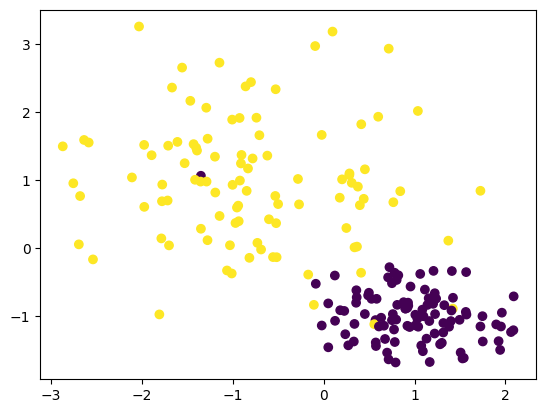

In [3]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

X, y = make_classification(n_samples=200,
                           n_features=2,
                           n_informative=2,
                           n_redundant=0,
                           n_repeated=0,
                           n_classes=2,
                           n_clusters_per_class=1,
                           random_state=37)

plt.figure()
plt.scatter(X[:,0],X[:,1],c=y)
plt.show()

## Modelo Perceptron:

Realizaremos nuestra propia implementación. Scikit-learn tiene una implementación de este modelo https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html.

In [4]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

class SPerceptron(object):
    '''
    Clasificador Perceptron
    '''

    def __init__(self, epocas=1, eta=1.):
        self.epocas = epocas    
        self.eta = eta  #tasa de aprendizaje

    def fit(self, X, y, show_error=False):
        '''
        Funcion de aprendizaje
        Entrada: datos de entrenamiento X,y en coordenadas homogeneas
        Calcula: W, los pesos del modelo, y el Error de aprendizaje
        '''         
        n_samples, n_features = X.shape                 
        self.W = np.zeros(n_features, dtype=np.float64) # inicializamos el vector de pesos
        self.W_history = []
        errors = []
        # --- cambiamos las etiquetas 0 por -1 ---
        y_new = y.copy()
        y_new[y_new==0] = -1
        # --- iteramos en las épocas ---
        for e in range(self.epocas):
            total_error = 0
            for i in range(n_samples):
                if self.pred(X[i])*y_new[i] <= 0:
                    self.W_history.append(self.W.copy())
                    self.W += y_new[i] * self.eta * X[i]
                    total_error += self.pred(X[i])*y_new[i]
            errors.append(total_error)
        self.W_history.append(self.W.copy())
        if show_error:
            xticks=np.arange(self.epocas)
            plt.xticks(xticks,[str(x) for x in xticks])
            plt.plot(errors,label='Perceptron')
            plt.xlabel('Epoca')
            plt.ylabel('Error total')
            plt.legend()
        
    def pred(self, X):
        '''
        Funcion que determina el signo de la predicción
        Entrada: arreglo numpy de datos X
        Salida:  arreglo numpy con valores +1 o -1 
        '''         
        return np.sign(X@self.W).astype(int)

    def predict(self, X):
        '''
        Funcion que determina el signo de la predicción
        Entrada: arreglo numpy de datos X
        Salida:  arreglo numpy con valores +1 o -1 
        '''   
        y_pred = self.pred(X)
        y_pred[y_pred == -1] = 0
        return y_pred
    
    def metricas(self, X, y):
        '''
        Funcion de evaluacion del rendimiento
        Entrada: arreglos numpy con datos de prueba y prediccion
        Salida: exactitud, precision y recall          
        ''' 
        y_pred = self.predict(X)
        accuracy = accuracy_score(y,y_pred)
        precision = precision_score(y,y_pred)
        recall = recall_score(y,y_pred)
        return {'accuracy':accuracy, 
                'precision':precision, 
                'recall':recall}
    
    def f(self,x,c=0):
        '''
        dados x y w, regresa 'y' tal que '(x,y)' esta sobre la linea
        w.x + b = c
        w es el vector ortogonal a la recta
        '''
        v = (-self.W[1]*x - self.W[0] + c) / self.W[2]
        return v

    
    def plot_FD(self,ax):
        '''
        Calcula los puntos de la linea recta 
        que representa la frontera de decision de un perceptron lineal
        Entrada: datos de las dos clases X1 y X2
        Salida: dos puntos extremos de la frontera de decision
        '''
        xmin, xmax = ax.get_xlim()
        ymin, ymax = ax.get_ylim()
        a0 = xmin
        a1 = self.f(a0)
        b0 = xmax 
        b1 = self.f(b0) 
        x=[a0,b0]
        y=[a1,b1]
        ax.plot(x, y, "k", label='Perceptron')
        ax.set_xlim(xmin,xmax)
        ax.set_ylim(ymin,ymax)
        ax.xaxis.grid(False)
        ax.yaxis.grid(False)
        legend = plt.legend(loc='upper center',
                    bbox_to_anchor=(0.5, 1.15),
                    ncol=4,
                    fancybox=True,
                    shadow=False)
        frame = legend.get_frame()
        frame.set_facecolor('white')
        frame.set_alpha(1)
        return ax


## Prueba del Perceptrón

In [5]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=19)

features = PolynomialFeatures(1)
X_train = features.fit_transform(x_train)
X_test = features.transform(x_test)

{'accuracy': 0.96875, 'precision': 0.9868421052631579, 'recall': 0.9493670886075949}


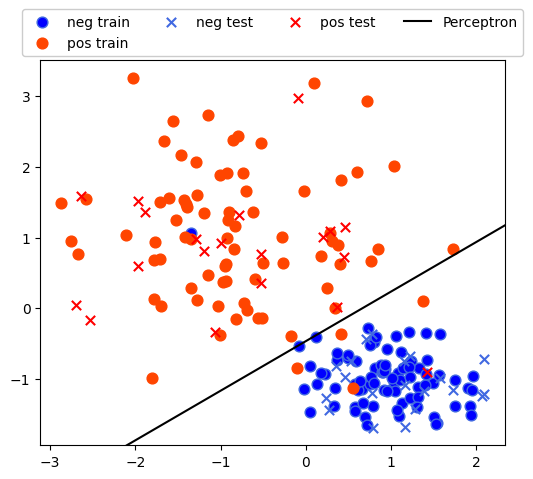

In [6]:
clf = SPerceptron()
# entrenamiento:
clf.fit(X_train, y_train)
# métricas de rendimiento:
print(clf.metricas(X_train,y_train))
# graficamos
fig,ax = grafica(x_train,y_train,x_test,y_test)
clf.plot_FD(ax)
fig.show()

Implementación del perceptron con kernel

In [27]:
#@title Perceptron con Kernel
class PerceptronKernel():
    """
    Perceptron con Kernel básico
    """
    def __init__(self, kernel='lk',**params):
        self.epocas=1
        if kernel == 'lk':
            self.__kernel=self.__lk
            self.clave = 'K-Lineal'
        elif kernel == 'gk':
            self.__kernel=self.__gk
            self.clave = 'K-Gauss'
        else:
            self.__kernel=self.__pk
            self.clave = 'K-Poli'
        if params:
            for p in params.keys():
                if p=='epocas':
                    self.epocas = params[p]
                    continue
                if p=='gamma':
                    self.gamma=params[p]

    def __lk(self,Xi,Xj):
        return Xi@Xj
    
    def __pk(self,Xi,Xj):
        return (1 + Xi@Xj)**self.gamma

    def __gk(self,Xi, Xj):
        return np.exp(-self.gamma*np.linalg.norm(Xi-Xj)**2)

    @property    
    def kernel(self):
        return self.__kernel
    
    @kernel.setter
    def kernel(self,*args):
        try:
            l=args[0]
            ok=True
            if isinstance(l,str):
                kernel=l
            else:
                kernel=l[0]
                try:
                    parametro=l[1]
                except IndexError:
                    print("ERROR: Debes pasar también un parámetro-> gamma > 0")
                    ok=False
        except IndexError:
            print("ERROR: Debes pasar al menos un argumento con la etiqueta del kernel: {lk,gk,pk}")
            ok=False
        if ok:
            if kernel == 'lk':
                self.__kernel=self.__lk
                self.clave = 'K-Lineal'          #para la leyenda de la imagen
            elif kernel == 'gk':
                self.gamma = parametro       #gamma del kernel gaussiano
                self.__kernel=self.__gk
                self.clave = 'K-Gauss'
            else:
                self.gamma = parametro       #gamma del kernel gaussiano
                self.__kernel=self.__pk
                self.clave = 'K-Poli' 
        return

    def fit(self, X, y):
        """
        Funcion de aprendizaje
        In: X, matriz de instancias de aprendizaje
            y, matriz de clases
        Out: alpha vector de pesos de instancias de aprendizaje
        """         
        n_samples, n_features = X.shape
        self.alpha = np.zeros(n_samples, dtype=np.float64)
        
        clases = np.unique(y).astype(int)
        if clases[0]==0:
            y_temp=y[:]
            y_temp[y==0]=-1
            self.__y=y_temp[:]
            y_temp=[]
        else:
            self.__y=y[:]

        # Gram matrix
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(X[i], X[j])

        # Entrenamiento
        for epoca in range(self.epocas):
            for i in range(n_samples):
                if self.__y[i]*np.sign(np.sum(K[i,:] * self.alpha * self.__y))<=0:
                    self.alpha[i] += 1.0

        # Support vectors
        sv = self.alpha > 1e-5
        ind = np.arange(len(self.alpha))[sv]
        self.alpha = self.alpha[sv]
        self.sv = X[sv]
        self.sv_y = self.__y[sv]
        print("{0} vectores de soporte de {1} puntos".format(len(self.alpha),n_samples))

    def decision_function(self, X):
        y_predict = np.zeros(len(X))
        for i in range(len(X)):
            s = 0
            for a, sv_y, sv in zip(self.alpha, self.sv_y, self.sv):
                s += a * sv_y * self.__kernel(X[i], sv)
            y_predict[i] = s
        return y_predict

    def predict(self, X):
        return np.sign(self.decision_function(X))
    
    
    def metricas(self, X, y):
        '''
        Funcion de evaluacion del rendimiento
        Entrada: arreglos numpy con datos de prueba y prediccion
        Salida: exactitud, precision y recall          
        ''' 
        y_pred = self.predict(X)
        y_pred[y_pred==-1] = 0
        accuracy = accuracy_score(y,y_pred)
        precision = precision_score(y,y_pred)
        recall = recall_score(y,y_pred)
        return {'accuracy':accuracy, 
                'precision':precision, 
                'recall':recall}

# Comparación de los métodos lineales

En este ejercicio vamos a comparar la clasificación y la frontera de decisión del clasificador de la sesión anterior (discriminante lineal OLS) con el SVM con kernel lineal.

Para esto, vamos a usar ambos clasificadores en el mismo conjunto de datos. Después, compararemos la frontera de decisión.

In [7]:
url = "https://raw.githubusercontent.com/DCDPUAEM/DCDP/main/02-Machine-Learning/data/clasificador_lineal.py"
!wget --no-cache --backups=1 {url}

--2023-04-29 14:10:36--  https://raw.githubusercontent.com/DCDPUAEM/DCDP/main/02-Machine-Learning/data/clasificador_lineal.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 840 [text/plain]
Failed to rename clasificador_lineal.py to clasificador_lineal.py.1: (2) No such file or directory
Saving to: ‘clasificador_lineal.py’

clasificador_lineal 100%[===================>]     840  --.-KB/s    in 0s      

2023-04-29 14:10:36 (25.3 MB/s) - ‘clasificador_lineal.py’ saved [840/840]



In [8]:
from clasificador_lineal import LeastSquaresClassifier

Definimos el conjunto de datos, usaremos un dataset de scikit-learn:

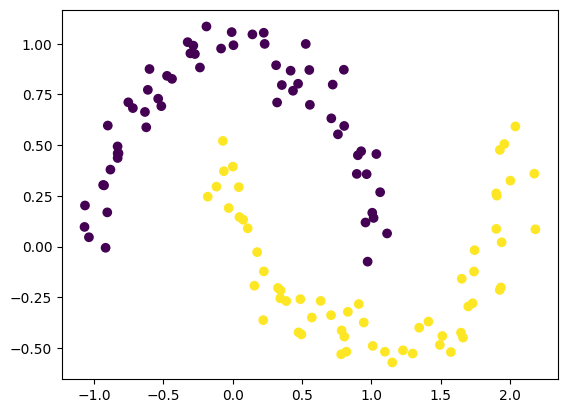

In [9]:
from sklearn.datasets import make_moons

x_train, y_train = make_moons(n_samples = 120, random_state=89,noise=0.1,)
# x_train, y_train = make_blobs(n_samples = 120, centers=2, random_state=89,noise=0.1)

#--- Lo graficamos para verlo ---
plt.figure()
plt.scatter(x_train[:,0], x_train[:,1], c=y_train)
plt.show()

Realiza la clasificación usando el clasificador OLS y grafica la frontera de decisión.
Puedes usar el código para clasificar y graficar que usamos ayer

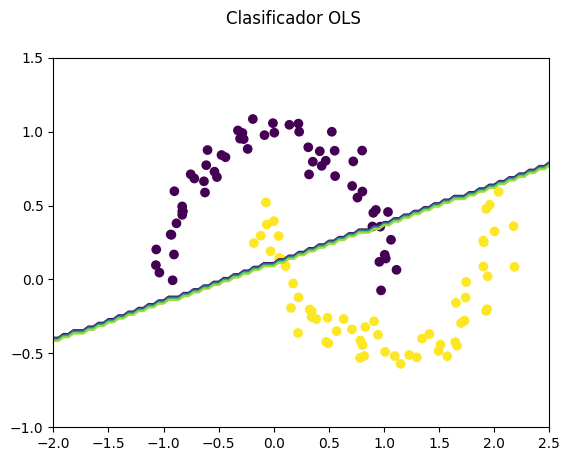

In [10]:
from sklearn.preprocessing import PolynomialFeatures

x1_test, x2_test = np.meshgrid(np.linspace(-2, 2.5, 100), np.linspace(-1, 1.5, 100))
x_test = np.array([x1_test, x2_test]).reshape(2, -1).T

features = PolynomialFeatures(1)
X_train = features.fit_transform(x_train)
X_test = features.transform(x_test)

modelo = LeastSquaresClassifier()   # Creamos la instancia del clasificador
modelo.fit(X_train,y_train)         # 
y_ols = modelo.clasifica(X_test)

plt.figure()
plt.suptitle("Clasificador OLS")
#-----Dibujar los datos---------------------------------
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
#-----Dibujar X_test (la malla de fondo para ver las regiones ------------
plt.contour(x1_test, x2_test, y_ols.reshape(100, 100))
plt.show()

Ahora, usemos SVM lineal. Realiza la clasificación en el mismo dataset, usando SVM con kernel lineal y grafica la frontera de decisión.
Puedes usar el código para clasificar y graficar que usamos anteriormente

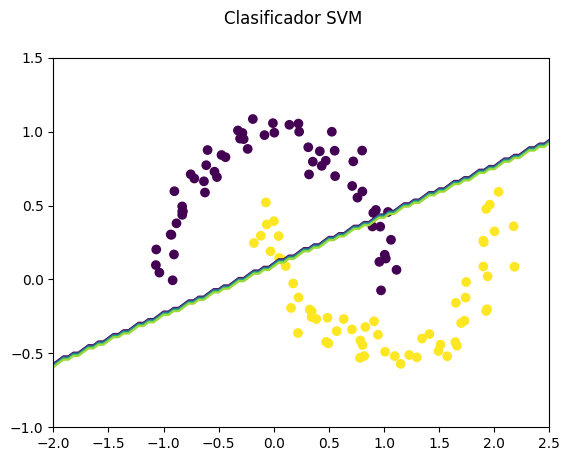

In [11]:
from sklearn.svm import SVC

x1_test, x2_test = np.meshgrid(np.linspace(-2, 2.5, 100), np.linspace(-1, 1.5, 100))
x_test = np.array([x1_test, x2_test]).reshape(2, -1).T

lin_svm = SVC(kernel='linear')
lin_svm.fit(x_train, y_train)
y_svm = lin_svm.predict(x_test)

plt.figure()
plt.suptitle("Clasificador SVM")
#-----Dibujar los datos---------------------------------
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
#-----Dibujar X_test (la malla de fondo para ver las regiones ------------
plt.contour(x1_test, x2_test, y_svm.reshape(100, 100))
plt.show()


Probemos con el perceptron

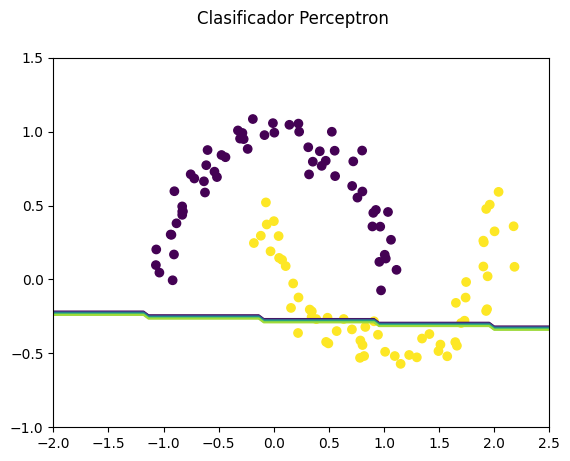

In [12]:
from sklearn.preprocessing import PolynomialFeatures

x1_test, x2_test = np.meshgrid(np.linspace(-2, 2.5, 100), np.linspace(-1, 1.5, 100))
x_test = np.array([x1_test, x2_test]).reshape(2, -1).T

features = PolynomialFeatures(1)
X_train = features.fit_transform(x_train)
X_test = features.transform(x_test)

modelo = SPerceptron()   
modelo.fit(X_train,y_train)        
y_perc = modelo.predict(X_test)

plt.figure()
plt.suptitle("Clasificador Perceptron")
#-----Dibujar los datos---------------------------------
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
#-----Dibujar X_test (la malla de fondo para ver las regiones ------------
plt.contour(x1_test, x2_test, y_perc.reshape(100, 100))
#-----Formato de la gráfica------------------------
plt.show()

Usemos el perceptron de scikit learn. Este estimador no usa el kernel.

0.8083333333333333


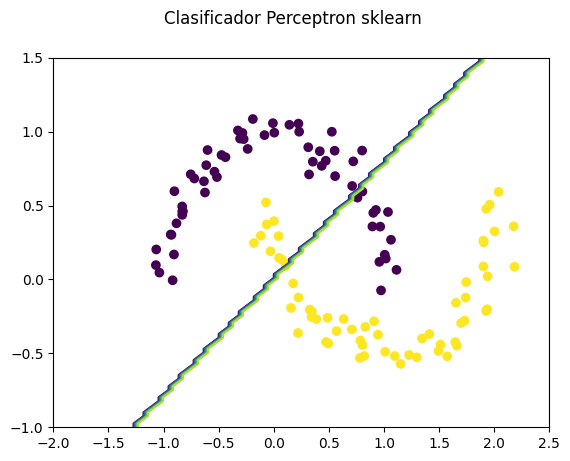

In [19]:
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import PolynomialFeatures

x1_test, x2_test = np.meshgrid(np.linspace(-2, 2.5, 100), np.linspace(-1, 1.5, 100))
x_test = np.array([x1_test, x2_test]).reshape(2, -1).T


modelo = Perceptron(penalty='l2',alpha=0.5,
                    early_stopping=True,
                    eta0=0.2)   
modelo.fit(x_train,y_train)        
print(modelo.score(x_train,y_train))
y_perc_sk = modelo.predict(x_test)

plt.figure()
plt.suptitle("Clasificador Perceptron sklearn")
#-----Dibujar los datos---------------------------------
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
#-----Dibujar X_test (la malla de fondo para ver las regiones ------------
plt.contour(x1_test, x2_test, y_perc_sk.reshape(100, 100))
#-----Formato de la gráfica------------------------
plt.show()


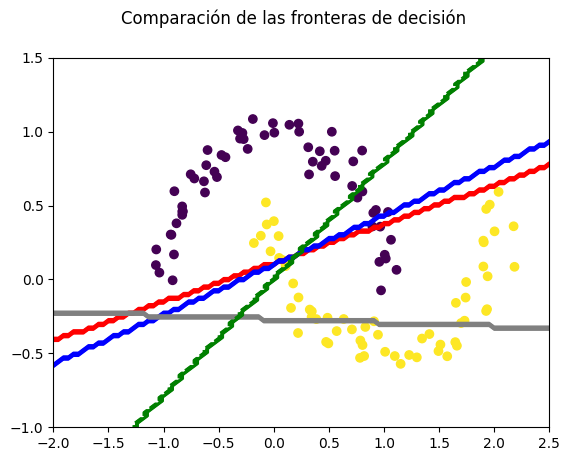

In [24]:
plt.figure()
plt.suptitle("Comparación de las fronteras de decisión")
#-----Dibujar los datos---------------------------------
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
#-----Dibujar X_test (la malla de fondo para ver las regiones ------------
plt.contour(x1_test, x2_test, y_ols.reshape(100, 100),colors='red')
plt.contour(x1_test, x2_test, y_svm.reshape(100, 100),colors='blue')
plt.contour(x1_test, x2_test, y_perc.reshape(100, 100),colors='gray')
plt.contour(x1_test, x2_test, y_perc_sk.reshape(100, 100),colors='green')
plt.show()

Probemos el perceptron con kernel

22 vectores de soporte de 120 puntos


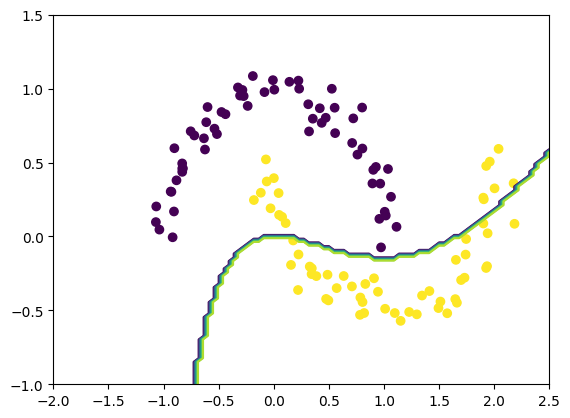

In [28]:
from sklearn.preprocessing import PolynomialFeatures

x1_test, x2_test = np.meshgrid(np.linspace(-2, 2.5, 100), np.linspace(-1, 1.5, 100))
x_test = np.array([x1_test, x2_test]).reshape(2, -1).T

features = PolynomialFeatures(1)
X_train = features.fit_transform(x_train)
X_test = features.fit_transform(x_test)

modelo = PerceptronKernel(kernel='pk',gamma=3) # Kernel polinomial
# modelo = PerceptronKernel(kernel='gk',gamma=1) # Kernel RBF   
modelo.fit(X_train,y_train)        
y_perc_k = modelo.predict(X_test)

plt.figure()
#-----Dibujar los datos---------------------------------
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
#-----Dibujar X_test (la malla de fondo para ver las regiones ------------
plt.contour(x1_test, x2_test, y_perc_k.reshape(100, 100))
#-----Formato de la gráfica------------------------
plt.show()

#⭕ Práctica 1

Considera los siguientes 3 datasets. 


1.   Entrena un clasificador lineal (SVM lineal, OLS, Perceptron), grafica la frontera de decisión junto con el conjunto de entrenamiento. Reporta la matriz de confusión, accuracy y recall.
2.   Entre un clasificador lineal con kernel (SVM) para lograr el mejor posible accuracy. Puedes usar gridsearch. Grafica la frontera de decisión junto con el conjunto de entrenamiento.



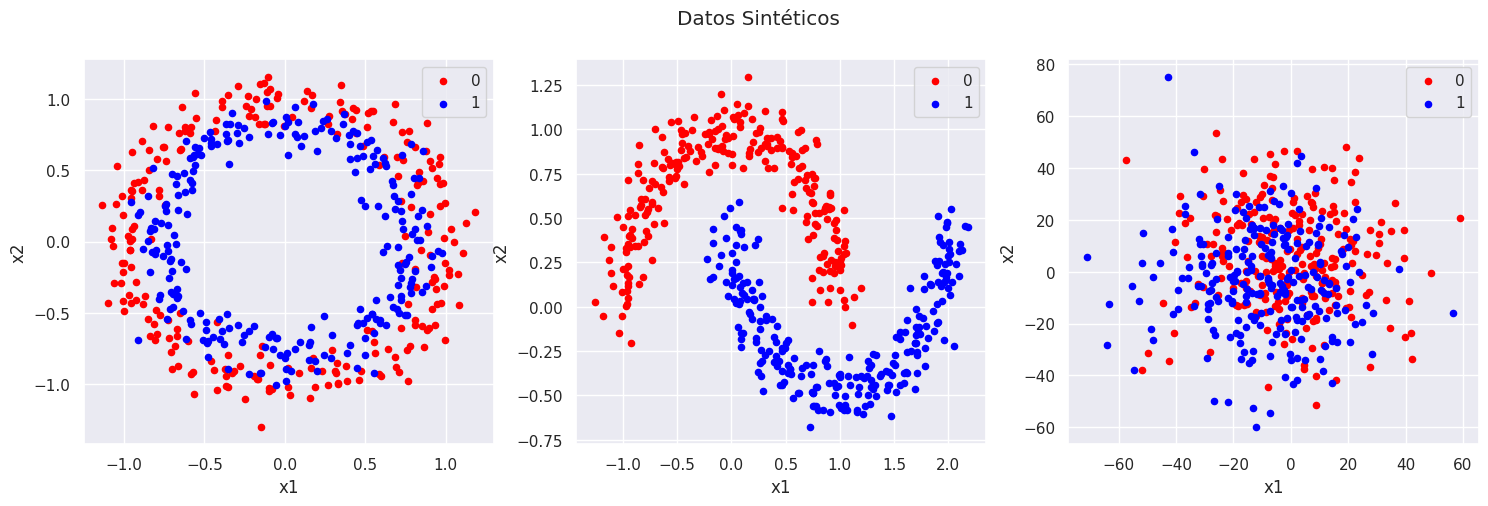

In [45]:
from sklearn.datasets import make_blobs, make_circles, make_moons
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set();

exp_size = 500

# --- Los datasets ---
X_circ, y_circ = make_circles(n_samples=exp_size, noise=0.1,
                              random_state=1)
X_moon, y_moon = make_moons(n_samples=exp_size, noise=0.1,
                            random_state=1)
X_blob, y_blob = make_blobs(n_samples=exp_size, centers=2, cluster_std= 20,
                            n_features=2,random_state=1)

# scatter plot, dots colored by class value
df_circ = pd.DataFrame(dict(x1 = X_circ[:,0], x2=X_circ[:,1], label=y_circ))
df_moon = pd.DataFrame(dict(x1 = X_moon[:,0], x2=X_moon[:,1], label=y_moon))
colors_bin = {0:'red', 1:'blue'}

df_blob = pd.DataFrame(dict(x1 = X_blob[:,0], x2=X_blob[:,1], label=y_blob))
colors_mult = {0:'red', 1:'blue', 2:'green', 3:'purple'}

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,5))
fig.suptitle('Datos Sintéticos')

grouped = df_circ.groupby('label')
for key, group in grouped:
    group.plot(ax=ax1, kind='scatter', x='x1', y='x2', label=key, color=colors_bin[key])

grouped = df_moon.groupby('label')
for key, group in grouped:
    group.plot(ax=ax2, kind='scatter', x='x1', y='x2', label=key, color=colors_bin[key])

grouped = df_blob.groupby('label')
for key, group in grouped:
    group.plot(ax=ax3, kind='scatter', x='x1', y='x2', label=key, color=colors_mult[key])

#⭕ Práctica 2

Los atributos son:

1. Alcohol
2. Malic acid
3. Ash
4. Alcalinity of ash  
5. Magnesium
6. Total phenols
7. Flavanoids
8. Nonflavanoid phenols
9. Proanthocyanins
10. Color intensity
11. Hue
12. OD280/OD315 of diluted wines
13. Proline   

In [ ]:
!apt-get -qq install > /dev/null subversion

!svn checkout "https://github.com/DCDPUAEM/DCDP/trunk/02-Machine-Learning/data/"

# ⏸ Visualizar el entrenamiento (opcional)

En esta sección se muestra como graficar el proceso del entrenamiento.

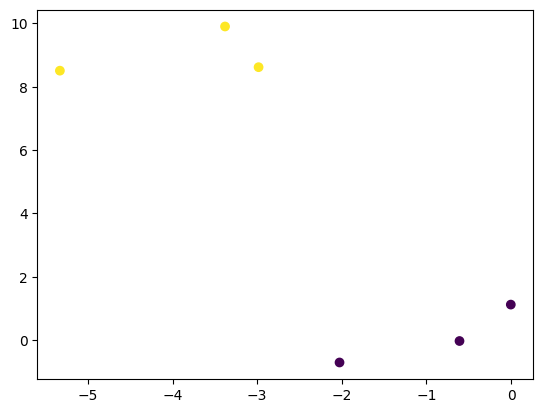

{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0}

In [ ]:
from sklearn.datasets import make_blobs

x, y = make_blobs(n_samples=6,random_state=945,centers=2)

plt.figure()
plt.scatter(x[:,0],x[:,1],c=y)
plt.show()

features = PolynomialFeatures(1)
X = features.fit_transform(x)

clf = Perceptron(epocas=10,eta=5)
clf.fit(X, y)
Ws = clf.W_history
y_pred = clf.predict(X)
clf.metricas(X,y)

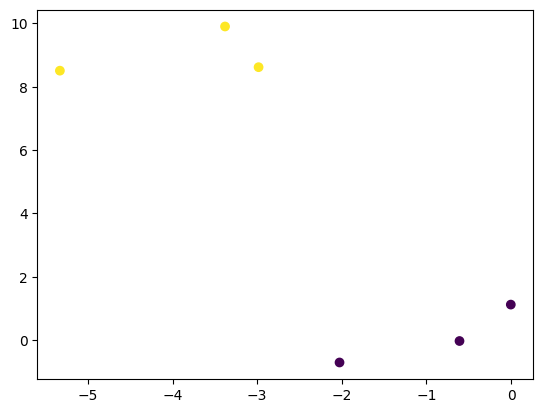

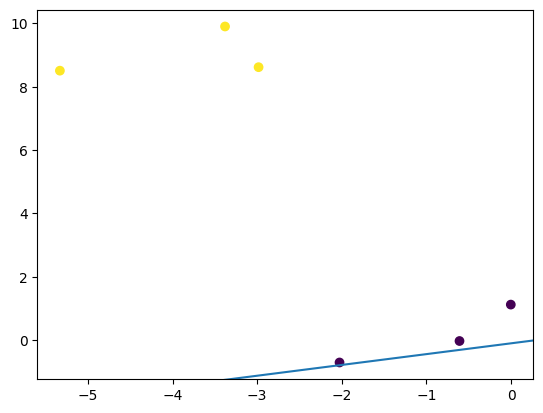

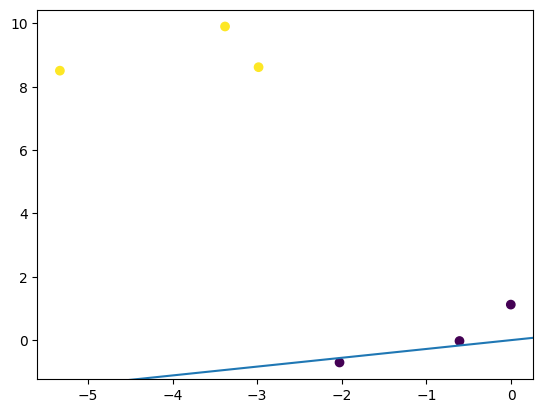

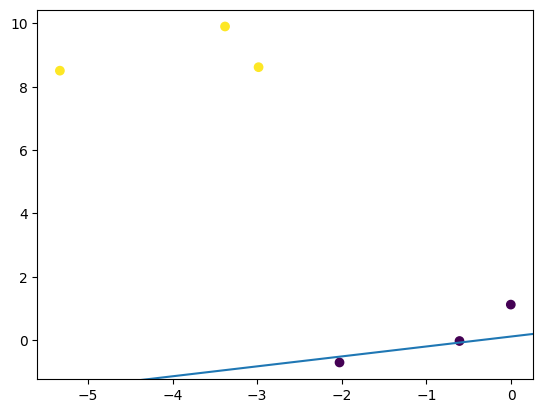

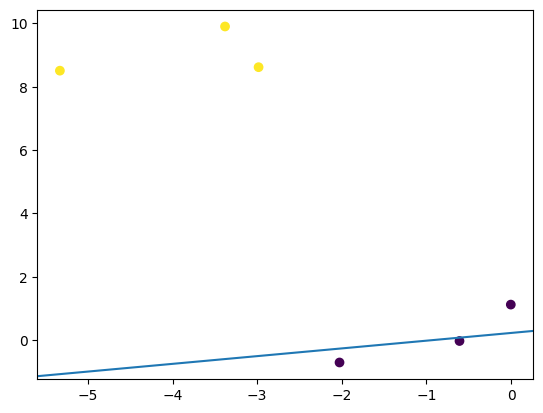

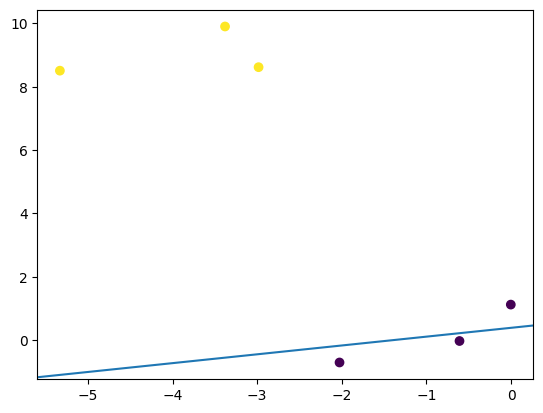

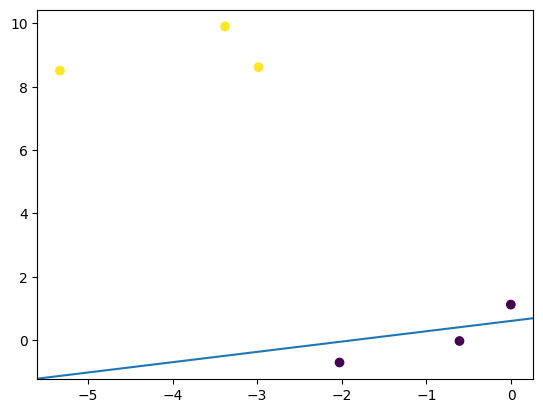

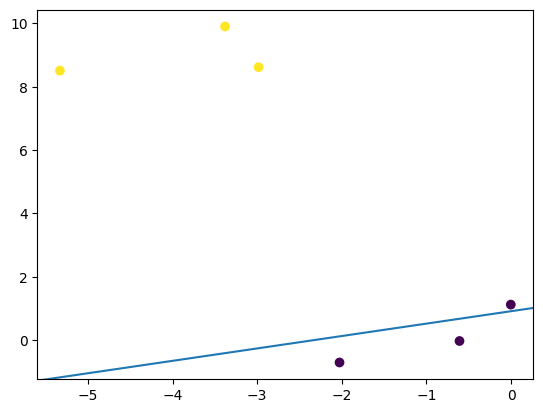

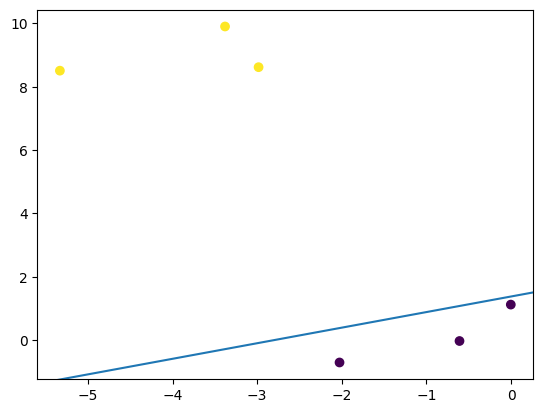

In [ ]:
xmin = np.min(x[:,0])
xmax = np.max(x[:,0])
xs = np.linspace(xmin-0.5,xmax+0.5,num=100)

def f(x,w):
    return (-w[0] - w[1]*x) / w[2]

for j,w in enumerate(Ws):
    fig = plt.figure()
    ax = fig.subplots()
    ax.scatter(x[:,0],x[:,1],c=y)
    if np.linalg.norm(w)!=0:
        xlims = ax.get_xlim()
        ylims = ax.get_ylim()
        ax.plot(xs,[f(x,w) for x in xs])
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
    if j<10:
        fig.savefig(f"perceptron-ex-0{j}.png")
    else:
        fig.savefig(f"perceptron-ex-{j}.png")
    fig.show()    